In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import altair as alt
alt.renderers.enable('notebook')
print(os.listdir("../input"))
from IPython.display import HTML


# The below is great for working but if you publish it, no charts show up.
# The workaround in the next cell deals with this.
#alt.renderers.enable('notebook')

HTML("This code block contains import statements and setup.")
# Any results you write to the current directory are saved as output.

[]


In [2]:
## Dont worry about the code in this block. This is just the setup for showing Altair graphs in Kaggle Notebooks


from  altair.vega import v3
import json
from IPython.display import HTML


vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
    "This code block sets up embedded rendering in HTML output and<br/>",
    "provides the function `render(chart, id='vega-chart')` for use below."
)))


In [3]:
#!pip install fbprophet

# Getting the data

In [4]:
from fbprophet import Prophet

!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = np.loadtxt("dataset/sunspots.txt", float)

Continuing in background, pid 51.
Output will be written to ‘wget-log’.


In [5]:
!ls dataset/

sunspots.txt


### Converting data to Pandas dataframe

In [6]:
# View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.tail(10)

,Months,SunSpots
3133,3133.0,18.8
3134,3134.0,15.4
3135,3135.0,8.0
3136,3136.0,8.7
3137,3137.0,13.6
3138,3138.0,16.1
3139,3139.0,19.6
3140,3140.0,25.2
3141,3141.0,23.5
3142,3142.0,21.6


In [7]:
data_as_frame['ds']=data_as_frame['Months'].astype(int)

In [8]:
data_as_frame.head()

,Months,SunSpots,ds
0,0.0,58.0,0
1,1.0,62.6,1
2,2.0,70.0,2
3,3.0,55.7,3
4,4.0,85.0,4


### Converting the months column in format acceptable for Prophet, starting from 1749 

In [9]:
 data_as_frame['time_stamp']=data_as_frame.apply(lambda x:(pd.Timestamp('1749-01-01')+pd.DateOffset(months = int(x['ds']))),axis=1)

In [10]:
#Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame.drop(['Months','ds'],axis=1)

In [11]:
clean_df.head()

,SunSpots,time_stamp
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01


## Lets view the data in graphical format

In [12]:
render(alt.Chart(clean_df).mark_line(size=15, opacity=0.8, color = 'Orange').encode(
        x='yearmonthdate(time_stamp):T',
        y=alt.Y('SunSpots', title='Sunspots'),    
        tooltip=['yearmonthdate(time_stamp)', 'SunSpots']
    ).interactive().properties(width=900, height=450,title='Sunspots based on Months')\
              .configure_title(fontSize=20))

# Preparing data for modelling in Prophet

In [13]:
## Prophet requires two columns, one is ds (the date time) and y (variable to be forecasted)
clean_df.columns = ['y', 'ds']

## Lets Predict

Displaying Prophet plot


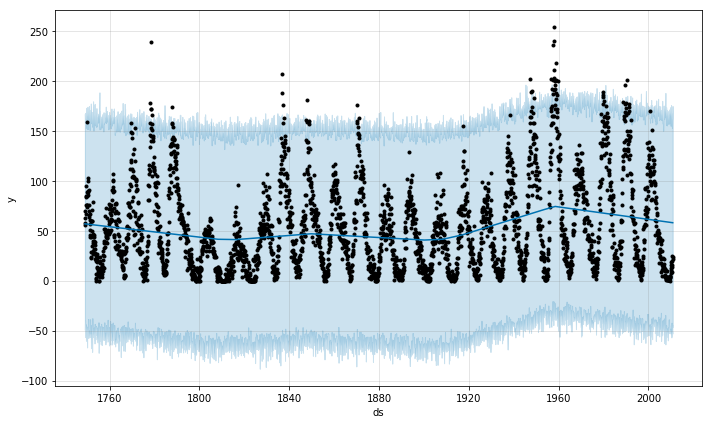

In [14]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)


# Detecting Anomalies:
* The light blue boundaries in the above graph are yhat_upper and yhat_lower.
* If y value is greater than yhat_upper and less than yhat lower then it is an anomaly.
* Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower.

In [15]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [16]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1749-01-01,56.852834,56.852834,-49.289875,167.030593,58.0,0,0.0
1,1749-02-01,56.830622,56.830622,-39.831669,158.891237,62.6,0,0.0
2,1749-03-01,56.810559,56.810559,-44.700962,167.899626,70.0,0,0.0
3,1749-04-01,56.788347,56.788347,-56.410340,152.661184,55.7,0,0.0
4,1749-05-01,56.766851,56.766851,-46.262237,156.411460,85.0,0,0.0


# Plotting the anomalies for a better view

In [17]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return render(alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20))
              
plot_anomalies(pred)

References:
* http://www-personal.umich.edu/~mejn/cp/programs.html
* https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f
* https://github.com/altair-viz/altair/issues/1270
